# Perturbation Theory

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [1]:
import numpy as np
import autograd.numpy as np
from autograd import grad

import scipy
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

### Self Energy expression

We compute the self-energy obtained from the perturbative Ansatz and find the energy that fulfills the self-consistent equation.

In [2]:
def integrate_self_energy(V_0, tx, ty, B, E):
    E_self = lambda kx, ky: (2*V_0**2)/(4*np.pi**2)*(1-np.cos(kx)*np.cos(ky))/(B-E-2*tx*np.cos(kx)-2*ty*np.cos(ky)) 
    E_self_int = scipy.integrate.dblquad(E_self, -np.pi,np.pi, -np.pi,np.pi, epsabs=1.49e-10, epsrel=1.49e-10)
    return E_self_int

def find_Ep(V_0, tx, ty, B, E_guess):
    E_self_int = lambda E: E+integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0]
    E_min = scipy.optimize.fsolve(E_self_int, [E_guess])
    return E_min
    
def guess_Ep(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718

Here we define functions that compute the vGH and perturbative energies for different potentials.

In [3]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
        print('V0 =', V_0_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])+'_'
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]

        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

### Define the calculation parameters

In [4]:
params = {"n": 256,
"M": 36,
"Mx": 16,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 16,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-10}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

### Perturbation Energies

TODO: make plot for the symmetric case that compares with the perturbation theory - now fixed the coupling points for which we want to compare! Cluster calculations for this are running, don't forget to collect them!! Also, a side benefit is that they provide nice convergence with system size calculations now!!

In [5]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_range = np.append(V_0_range1, V_0_range2)

In [73]:
params["B"] = 2.0
params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
Ep_pert1_B_1 = pert_pot_scan(params, V_0_range_vGH_B_2)
E_pert1_B_1 = get_E_from_Ep(Ep_pert1_B_1, params["tx"], params["ty"])


Perturbative Calculations:
V0 = 0.0 , E = 0j
V0 = 0.2 , E = (-0.00025059114284855594+0j)
V0 = 0.4 , E = (-0.0010023594194729247+0j)
V0 = 2.0 , E = (-0.025054881523010036+0j)
V0 = 4.0 , E = (-0.10016849523697217+0j)
V0 = 20.0 , E = (-2.467375028700644+0j)
V0 = 40.0 , E = (-9.51090433369651+0j)
V0 = 80.0 , E = (-34.37847104801114+0j)
V0 = 100.0 , E = (-50.81260874667429+0j)


In [74]:
#V_0_range = np.linspace(0,100,21)

params["B"] = 2.0
params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
Ep_pert1_B_1 = pert_pot_scan(params, V_0_range)
E_pert1_B_1 = get_E_from_Ep(Ep_pert1_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert1_B_200 = pert_pot_scan(params, V_0_range)
E_pert1_B_200 = get_E_from_Ep(Ep_pert1_B_200, params["tx"], params["ty"])



params["B"] = 1.0
params["tx"] = 50
params["ty"] = 150
Ep_pert2_B_1 = pert_pot_scan(params, V_0_range)
E_pert2_B_1 = get_E_from_Ep(Ep_pert2_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert2_B_200 = pert_pot_scan(params, V_0_range)
E_pert2_B_200 = get_E_from_Ep(Ep_pert2_B_200, params["tx"], params["ty"])



params["B"] = 1.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_1 = pert_pot_scan(params, V_0_range)
E_pert3_B_1 = get_E_from_Ep(Ep_pert3_B_1, params["tx"], params["ty"])

params["B"] = 200.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_200 = pert_pot_scan(params, V_0_range)
E_pert3_B_200 = get_E_from_Ep(Ep_pert3_B_200, params["tx"], params["ty"])


Perturbative Calculations:
V0 = 0.0 , E = 0j
V0 = 0.5 , E = (-0.001566180573677739+0j)
V0 = 1.0 , E = (-0.0062645217101342954+0j)
V0 = 1.5 , E = (-0.014094422161069377+0j)
V0 = 2.0 , E = (-0.025054881523010036+0j)
V0 = 2.5 , E = (-0.03914450272923439+0j)
V0 = 3.0 , E = (-0.05636149548734639+0j)
V0 = 3.5 , E = (-0.07670368061788621+0j)
V0 = 4.0 , E = (-0.10016849523697217+0j)
V0 = 4.5 , E = (-0.1267529987145917+0j)
V0 = 5.0 , E = (-0.1564538793364519+0j)
V0 = 5.5 , E = (-0.18926746159113322+0j)
V0 = 6.0 , E = (-0.22518971400189736+0j)
V0 = 6.5 , E = (-0.2642162574301484+0j)
V0 = 7.0 , E = (-0.306342373730853+0j)
V0 = 7.5 , E = (-0.3515630147332304+0j)
V0 = 8.0 , E = (-0.3998728115110062+0j)
V0 = 8.5 , E = (-0.4512660837212857+0j)
V0 = 9.0 , E = (-0.5057368490383581+0j)
V0 = 9.5 , E = (-0.5632788327490746+0j)
V0 = 10.0 , E = (-0.6238854772100852+0j)
V0 = 15.0 , E = (-1.396881860210741+0j)
V0 = 20.0 , E = (-2.467375028700644+0j)
V0 = 25.0 , E = (-3.82545995763773+0j)
V0 = 30.0 , E = (-5.

### vGH energies

#### Note: for big lattices, it is better to use the stand-alone python script! This cell is just suited for quick computations

Read in the vGH calculations from the wavefunctions.

In [72]:
V_0_range_vGH_B_2 = np.array([0.0,0.2,0.4,2,4,20,40,80,100])

check_sys = 'tx_100_ty_100'
check_sym = '_B_2.0_Mx_64_My_64_qx_0_qy_0'
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_1 = get_E_arr(V_0_range_vGH_B_2, folder, check_sys, check_sym)

check_sym = '_B_200.0_Mx_16_My_16'
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_50_ty_150'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_50_ty_150'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_10_ty_190'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_10_ty_190'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)

## Plot the results to show how the energies match!

In [69]:
def E_to_plot(E, t):
    return np.abs(E+2*t)/t

In [70]:
print(E_vGH1_B_1)

NameError: name 'E_vGH1_B_1' is not defined

In [ ]:
print(E_vGH1_B_1)

In [ ]:
E_pert1_B_1-E_vGH1_B_1

In [ ]:
E_pert1_B_1-E_vGH1_B_1

In [ ]:
plt.plot(V_0_range, E_vGH1_B_1.real, color='tab:blue', linestyle='dashed')
plt.plot(V_0_range, E_vGH1_B_200.real, color='tab:blue')
plt.plot(V_0_range, E_pert1_B_1.real, color='tab:red')
plt.plot(V_0_range, E_pert1_B_200.real, color='tab:red', linestyle='dashed')
#plt.plot(V_0_range, E_pert3.real, color='tab:red')
#plt.plot(V_0_range, E_vGH3.real, color='tab:blue')

#plt.xscale('log')
#plt.yscale('log')

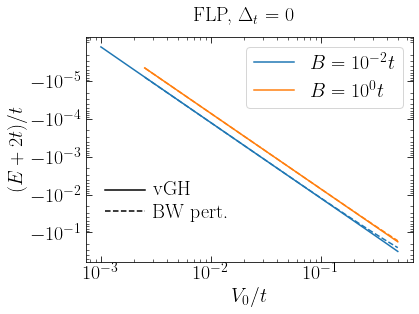

In [75]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FLP, $\Delta_t = 0$', fontsize=font_size)

axs.plot(V_0_range_vGH_B_2[1:]/t, E_to_plot(E_vGH1_B_1.real,t)[1:], color='tab:blue', linestyle='solid', label=r'$B = 10^{-2} t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_1.real,t)[1:], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH1_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(1.1e-3,2.5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(1.1e-3,2.5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.3*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.3*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/perturbation_theory/B_comp_tx_100_ty_100.svg', bbox_inches='tight')

In [ ]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FLP, $\Delta_t = 0.5$', fontsize=font_size)

axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_vGH2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_pert2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH2_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert2_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_50_ty_100.svg', bbox_inches='tight')

NameError: name 'E_to_plot' is not defined

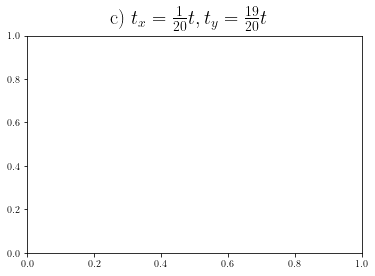

In [7]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_10_ty_190.svg', bbox_inches='tight')

In [ ]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $B = 0.5\cdot 10^{-2}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_1.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_1.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_0.01t.svg', bbox_inches='tight')

In [ ]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'd) $B = 10^{0}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_200.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_200.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.8e-3*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.3e-2*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-3), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-2), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_t.svg', bbox_inches='tight')

In [ ]:
plt.plot(V_0_range/t, E_to_plot(E_pert1.real,t), marker='x', color='tab:blue', linestyle='solid', label=r'$t_x = 100, t_y = 100$')
plt.plot(V_0_range/t, E_to_plot(E_vGH1.real,t), marker='x', color='tab:blue', linestyle='dashed')
plt.plot(V_0_range/t, (1/(1*(1+4*t))**0.5)*V_0_range**2/t, marker='x', color='tab:green', linestyle='dashed')


plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(V_0_range/t, 2*(0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')
plt.plot(V_0_range/t, (0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

In [ ]:
V_0_range = np.linspace(0,10,3)

params["tol"] = 1e-8

params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
E_pert1, E_vGH1 = get_energies(params,V_0_range)

print(E_pert1-E_vGH1)

## Perturbative prefactor analysis

Here we analyze the perturbative prefactor of the polaron energy, i.e. E_p = f(B,t_x,t_y)V_0^2 and we graphically determine the dependence of f(B,t_x,t_y).

In [52]:
def pert_B_scan(params, B_arr):
    E_arr = np.zeros(len(B_arr), dtype=complex)
    for i in range(len(B_arr)):
        E_min = find_Ep(params["V_0"], params["tx"], params["ty"], B_arr[i], -4.0872e-4) #guess_Ep(params["V_0"]))
        E_arr[i] = E_min[0]
        #print('B =', B_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_tx_ty(sum_tx_ty, diff_tx_ty):
    tx = 0.5*(sum_tx_ty+diff_tx_ty)
    ty = 0.5*(sum_tx_ty-diff_tx_ty)
    return tx, ty

def pert_B_sym_scan(params, sum_tx_ty, diff_tx_ty, B_arr):
    print('\nPerturbative Calculations:')
    
    E_arr = np.zeros((len(diff_tx_ty),len(B_arr)), dtype=complex)
    for i in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[i])

        params["tx"] = tx
        params["ty"] = ty

        E_arr[i] = pert_B_scan(params, B_arr)
        print('tx,ty=', tx,ty, ', E =', E_arr[i])
        
    return E_arr

/tmp/ipykernel_226783/3995237249.py:2: RuntimeWarning: invalid value encountered in scalar divide
  E_self = lambda kx, ky: (2*V_0**2)/(4*np.pi**2)*(1-np.cos(kx)*np.cos(ky))/(B-E-2*tx*np.cos(kx)-2*ty*np.cos(ky))
/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: Th

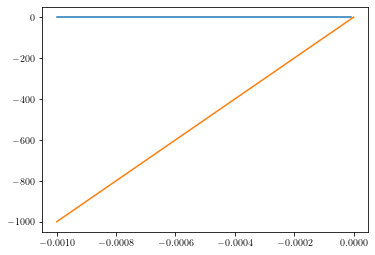

In [53]:
V_0_test = 0.001
B_test = 0

E_test = np.linspace(-0.001,0,100)
self_E = np.zeros(len(E_test))

for i in range(len(E_test)):
    self_E[i] = integrate_self_energy(V_0_test, 100, 100, B_test, E_test[i]-2*100-2*100)[0]/V_0_test**2
    #print(E_test[i],self_E[i])
    
plt.plot(E_test, -self_E)
plt.plot(E_test, E_test/V_0_test**2)


Perturbative Calculations:
tx,ty= 180.0 20.0 , E = [-0.0004244 +0.j -0.00042437+0.j -0.00042434+0.j -0.00042411+0.j
 -0.00042386+0.j -0.00042215+0.j -0.00042031+0.j -0.00040872+0.j
 -0.00039724+0.j]
tx,ty= 140.0 60.0 , E = [-0.00027784+0.j -0.00027783+0.j -0.00027782+0.j -0.00027775+0.j
 -0.00027768+0.j -0.00027714+0.j -0.00027655+0.j -0.00027272+0.j
 -0.00026876+0.j]
tx,ty= 100.0 100.0 , E = [-0.00025465+0.j -0.00025464+0.j -0.00025463+0.j -0.00025458+0.j
 -0.00025452+0.j -0.00025409+0.j -0.00025363+0.j -0.00025059+0.j
 -0.00024742+0.j]


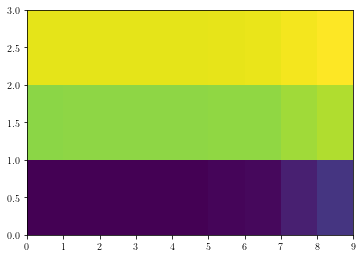

/tmp/ipykernel_226783/830820317.py:12: RuntimeWarning: divide by zero encountered in divide
  Ep_theory = -V_0_B_dep**2/np.sqrt(B_arr*(B_arr+4*sum_tx_ty))


In [54]:
V_0_B_dep = 0.2
params["V_0"] = V_0_B_dep

B_arr = np.array([0,0.002,0.004,0.02,0.04,0.2,0.4,2,4]) #np.linspace(0.002,0.02,3) #np.linspace(2,200,10)
diff_tx_ty = np.array([160,80,0]) #,80,0]) #np.linspace(-200,200,11)

sum_tx_ty = 200.0
Ep_B_sym_V_02 = pert_B_sym_scan(params, sum_tx_ty, diff_tx_ty, B_arr)


plt.pcolormesh(Ep_B_sym_V_02.real); plt.show()
Ep_theory = -V_0_B_dep**2/np.sqrt(B_arr*(B_arr+4*sum_tx_ty))

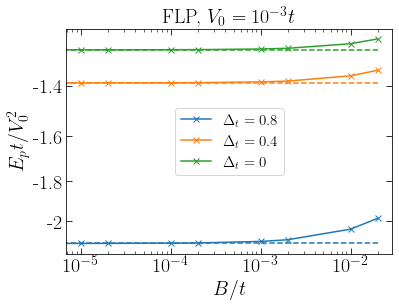

In [68]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots() 

plt.title(r'FLP, $V_0 = 10^{-3}t$', fontsize=font_size)

plt.plot((B_arr/sum_tx_ty)**1.0, -Ep_B_sym_V_02[0].real*sum_tx_ty/V_0_B_dep**2, marker='x', color='tab:blue', label=r'$\Delta_t = 0.8$')
plt.plot((B_arr/sum_tx_ty)**1.0, -Ep_B_sym_V_02[1].real*sum_tx_ty/V_0_B_dep**2, marker='x', color='tab:orange', label=r'$\Delta_t = 0.4$')
plt.plot((B_arr/sum_tx_ty)**1.0, -Ep_B_sym_V_02[2].real*sum_tx_ty/V_0_B_dep**2, marker='x', color='tab:green', label=r'$\Delta_t = 0$')
#plt.plot((B_arr/sum_tx_ty)**1.0, 2*sum_tx_ty/np.sqrt(B_arr*(B_arr+4*sum_tx_ty)), marker='x', label=r'try')
#plt.plot((B_arr/sum_tx_ty)**1.0, 2*sum_tx_ty/np.sqrt(B_arr*4*sum_tx_ty), marker='x', label=r'try')
#plt.plot(B_arr/sum_tx_ty, 2*Ep_theory/sum_tx_ty/V_0_B_dep**2, marker='x', label=r'1D, $t=200$')

# the following numbers were checked and numerically computed with Mathematica!
plt.hlines(y=2.12, xmin=np.min((B_arr/sum_tx_ty)**1.0), xmax=np.max((B_arr/sum_tx_ty)**1.0), color='tab:blue', linestyle='dashed')
plt.hlines(y=1.38922, xmin=np.min((B_arr/sum_tx_ty)**1.0), xmax=np.max((B_arr/sum_tx_ty)**1.0), color='tab:orange', linestyle='dashed')
plt.hlines(y=1.27324, xmin=np.min((B_arr/sum_tx_ty)**1.0), xmax=np.max((B_arr/sum_tx_ty)**1.0), color='tab:green', linestyle='dashed')

plt.xlabel(r'$B/t$', fontsize=font_size)
plt.ylabel(r'$E_p t/V_0^2$', fontsize=font_size)

#plt.xticks(fontsize=font_size)
#plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([2,1.8,1.6,1.4],[r'-2',r'-1.8',r'-1.6',r'-1.4'])

axs.legend(fontsize=15, loc=10)

plt.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True, labelsize=font_size)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)

#plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/perturbation_theory/prefactor_scan_polaron_energy.svg')


Perturbative Calculations:
tx,ty= 0.0 200.0 , E = [-0.19083006+0.j -0.05681883+0.j -0.04053444+0.j -0.03292019+0.j
 -0.02826172+0.j -0.02502817+0.j -0.02261113+0.j -0.02071406+0.j
 -0.01917268+0.j -0.01788758+0.j]
tx,ty= 20.0 180.0 , E = [-0.04084639+0.j -0.03274872+0.j -0.02831491+0.j -0.02523764+0.j
 -0.02291308+0.j -0.02106822+0.j -0.01955445+0.j -0.01828177+0.j
 -0.01719167+0.j -0.01624405+0.j]
tx,ty= 40.0 160.0 , E = [-0.03108593+0.j -0.02680224+0.j -0.02411016+0.j -0.0220758 +0.j
 -0.02044152+0.j -0.01908209+0.j -0.01792441+0.j -0.01692137+0.j
 -0.01604061+0.j -0.01525884+0.j]
tx,ty= 60.0 140.0 , E = [-0.02726634+0.j -0.02414285+0.j -0.02207426+0.j -0.02045503+0.j
 -0.01911822+0.j -0.01798139+0.j -0.01699539+0.j -0.01612783+0.j
 -0.01535596+0.j -0.01466303+0.j]
tx,ty= 80.0 120.0 , E = [-0.02555686+0.j -0.02289008+0.j -0.02108279+0.j -0.0196454 +0.j
 -0.01844356+0.j -0.01741069+0.j -0.01650685+0.j -0.0157055 +0.j
 -0.01498778+0.j -0.01433973+0.j]
tx,ty= 100.0 100.0 , E = [-0.0250

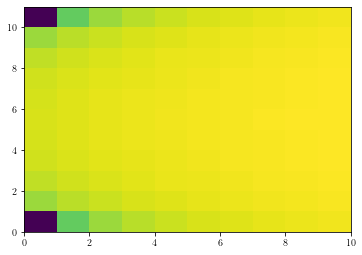

In [12]:
V_0_B_dep = 2
params["V_0"] = V_0_B_dep

B_arr = np.linspace(2,200,10)
diff_tx_ty = np.linspace(-200,200,11)

sum_tx_ty = 200.0
Ep_B_sym_V_2 = pert_B_sym_scan(params, sum_tx_ty, diff_tx_ty, B_arr)


plt.pcolormesh(Ep_B_sym_V_2.real); plt.show()

Ep_theory = -V_0_B_dep**2/np.sqrt(B_arr*(B_arr+4*sum_tx_ty))

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

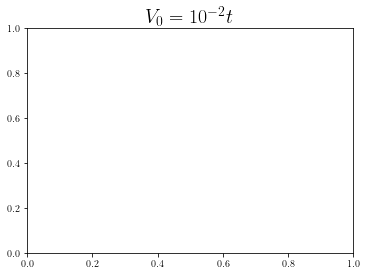

In [50]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots() 

plt.title(r'$V_0 = 10^{-2}t$', fontsize=font_size)

plt.plot(B_arr/sum_tx_ty, Ep_B_sym_V_2[1].real/sum_tx_ty/V_0_B_dep**2, marker='x', label=r'$t_x=20,t_y=180$')
plt.plot(B_arr/sum_tx_ty, Ep_B_sym_V_2[3].real/sum_tx_ty/V_0_B_dep**2, marker='x', label=r'$t_x=60,t_y=140$')
plt.plot(B_arr/sum_tx_ty, Ep_B_sym_V_2[5].real/sum_tx_ty/V_0_B_dep**2, marker='x', label=r'$t_x=100,t_y=100$')

plt.xlabel(r'$B/t$', fontsize=font_size)
plt.ylabel(r'$E_p/t/V_0^2$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

#axs.set_xscale('log', base=10)
#axs.set_yscale('log', base=10)

axs.legend(fontsize=15, loc=4)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

## Effective Mass Calculations

First, we define some functions that we use to compute the pert. effective masses.

In [14]:
def integrate_self_energy(V_0, tx, ty, B, E):
    E_self = lambda kx, ky: (2*V_0**2)/(4*np.pi**2)*(1-np.cos(kx)*np.cos(ky))/(B-E-2*tx*np.cos(kx)-2*ty*np.cos(ky))
    E_self_int = scipy.integrate.dblquad(E_self, -np.pi,np.pi, -np.pi,np.pi)
    return E_self_int

def find_Ep(V_0, tx, ty, B, E_guess):
    E_self_int = lambda E: E+integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0]
    E_min = scipy.optimize.fsolve(E_self_int, [E_guess])
    return E_min
    
def guess_Ep(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718
    
def find_first_deriv_self_energy(V_0, tx, ty, B, h):
    E_min = find_Ep(V_0, tx, ty, B, guess_Ep(V_0))-2*tx-2*ty
    
    E_self_int = lambda E: integrate_self_energy(V_0, tx, ty, B, E)[0].real
    
    E_min_prime = (E_self_int(E_min+h)-E_self_int(E_min))/h 
    return E_min_prime
    
def calc_eff_mass(self_E_prime, V_0, tx, ty, B):
    kx = 0
    ky = 0
    
    sec_deriv_band_x = 2*tx*np.cos(kx)
    sec_deriv_band_y = 2*ty*np.cos(ky)
    
    eff_mass_x = (1+self_E_prime)/sec_deriv_band_x
    eff_mass_y = (1+self_E_prime)/sec_deriv_band_y
    return eff_mass_x, eff_mass_y

In [15]:
def eff_mass_V_0_range(V_0_eff_mass_range, params):
    h = 1e-6
    
    eff_mass_x_arr = np.zeros(len(V_0_eff_mass_range))
    eff_mass_y_arr = np.zeros(len(V_0_eff_mass_range))
    for i in range(len(V_0_eff_mass_range)):
        V_0 = V_0_eff_mass_range[i]
    
        self_E_prime = find_first_deriv_self_energy(V_0, params["tx"], params["ty"], params["B"], h)
        eff_mass_x, eff_mass_y = calc_eff_mass(self_E_prime, V_0, params["tx"], params["ty"], params["B"])

        eff_mass_x_arr[i] = eff_mass_x
        eff_mass_y_arr[i] = eff_mass_y
        
        print('V_0,eff_mass =', V_0, eff_mass_x, eff_mass_y)
    return eff_mass_x_arr, eff_mass_y_arr

### Perturbative effective masses

In [16]:
V_0_eff_mass_range = np.array([0.0,0.02,0.04,0.2,0.4,0.6,1,4.0,6.0])  #np.linspace(0,1,11) #np.append(V_0_range1, V_0_range2)

params["B"] = 1
params["tx"] = 100
params["ty"] = 100 
print('Eff Mass cal for B = ', params["B"], ':\n')
eff_mass1_x_B_1, eff_mass1_y_B_1 = eff_mass_V_0_range(V_0_eff_mass_range, params)

params["B"] = 100
params["tx"] = 100
params["ty"] = 100
print('\nEff Mass cal for B = ', params["B"], ':\n')
eff_mass1_x_B_200, eff_mass1_y_B_200 = eff_mass_V_0_range(V_0_eff_mass_range, params)

Eff Mass cal for B =  1 :

V_0,eff_mass = 0.0 0.005 0.005
V_0,eff_mass = 0.02 0.005000000096517659 0.005000000096517659
V_0,eff_mass = 0.04 0.005000000386070155 0.005000000386070155
V_0,eff_mass = 0.2 0.00500000965170191 0.00500000965170191
V_0,eff_mass = 0.4 0.005000038601909213 0.005000038601909213
V_0,eff_mass = 0.6 0.005000086836158923 0.005000086836158923
V_0,eff_mass = 1.0 0.005000241050755745 0.005000241050755745
V_0,eff_mass = 4.0 0.00500379932953154 0.00500379932953154
V_0,eff_mass = 6.0 0.005008392524175616 0.005008392524175616

Eff Mass cal for B =  100 :

V_0,eff_mass = 0.0 0.005 0.005
V_0,eff_mass = 0.02 0.00500000002288498 0.00500000002288498
V_0,eff_mass = 0.04 0.005000000091539918 0.005000000091539918
V_0,eff_mass = 0.2 0.005000002288495321 0.005000002288495321
V_0,eff_mass = 0.4 0.005000009153951468 0.005000009153951468
V_0,eff_mass = 0.6 0.005000020596272084 0.005000020596272084
V_0,eff_mass = 1.0 0.005000057210841966 0.005000057210841966
V_0,eff_mass = 4.0 0.00500091

Function to get the variational energies.

In [17]:
def get_E_arr_eff_mass(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])+'_'
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]

        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

In [18]:
tx = 100
ty = 100
t = tx+ty

V_eff_mass_vGH = np.array([0.0,0.02,0.04,0.2,0.4,0.6,4.0,6.0,10]) # np.array([0.0,0.02,0.04,0.2,0.4,0.6])

params["Mx"] = 64
params["My"] = 64

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH1_q0 = get_E_arr_eff_mass(V_eff_mass_vGH, folder, check_sys, check_sym)

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_1_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH1_qx = get_E_arr_eff_mass(V_eff_mass_vGH, folder, check_sys, check_sym)

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_0_qy_1'
folder = 'results/eff_mass/fo/'
E_vGH1_qy = get_E_arr_eff_mass(V_eff_mass_vGH, folder, check_sys, check_sym)

print('V_0 :', V_eff_mass_vGH)
print('E q=0 :', E_vGH1_q0)
print('E qx=1 :', E_vGH1_qx)
print('E qy=1 :', E_vGH1_qy)

V_0 : [ 0.    0.02  0.04  0.2   0.4   0.6   4.    6.   10.  ]
E q=0 : [-400.        +0.00000000e+00j -400.00000233+6.42975374e-24j
 -400.00000955-8.89158026e-25j -400.00024808+1.64151177e-23j
 -400.0009993 +1.63813372e-23j -400.0022547 -8.14201342e-23j
 -400.10082448+1.52266584e-20j -400.22696785-4.96800835e-21j
    0.        +0.00000000e+00j]
E qx=1 : [-399.03694533+0.00000000e+00j -399.03694767+1.52387248e-21j
 -399.03695493-1.99397289e-20j -399.03719534-2.77564762e-15j
 -399.03795324+1.50943017e-20j -399.03922101+2.77533829e-15j
 -399.1390014 -1.38449365e-15j -399.26682307-5.54738257e-15j
    0.        +0.00000000e+00j]
E qy=1 : [-399.03694533+0.00000000e+00j -399.03694767-2.82224803e-20j
 -399.03695493-6.96322836e-20j -399.03719534-4.16338316e-15j
 -399.03795324+9.71432133e-15j -399.03922101+2.63676999e-14j
 -399.1390014 -1.66566938e-14j -399.26682307-3.46966226e-14j
    0.        +0.00000000e+00j]


In [19]:
def var_eff_mass(E_q, E_0, t, M):
    m_0_finite_diff = (t*M**2*(1-np.cos(2*np.pi/M))/np.pi**2)**(-1)
    return ((2*(E_q-E_0)/(2*np.pi/M)**2)**(-1))/m_0_finite_diff

m vGH = [ 0.    0.02  0.04  0.2   0.4   0.6   4.    6.   10.  ] [1.         1.00000001 1.00000005 1.000002   1.00000893 1.00002178
 1.00128047 1.00303067        nan]
m pert = [0.   0.02 0.04 0.2  0.4  0.6  1.   4.   6.  ] [1.         1.00000002 1.00000008 1.00000193 1.00000772 1.00001737
 1.00004821 1.00075987 1.0016785 ]
ratio m at V_0 = 0 : 1.0000000000000093


/tmp/ipykernel_226783/545042794.py:3: RuntimeWarning: invalid value encountered in reciprocal
  return ((2*(E_q-E_0)/(2*np.pi/M)**2)**(-1))/m_0_finite_diff


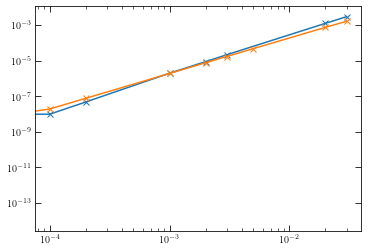

In [20]:
eff_mass_x_0 = 1/(2*tx)
eff_mass_y_0 = 1/(2*ty)

eff_mass_x_vGH_ratio = var_eff_mass(E_vGH1_qx, E_vGH1_q0, tx, 64).real #/eff_mass_x_0
eff_mass1_x_B_1_ratio = eff_mass1_x_B_1/eff_mass_x_0
eff_mass1_x_B_200_ratio = eff_mass1_x_B_200/eff_mass_x_0
fac = eff_mass_x_vGH_ratio[0]/eff_mass1_x_B_1_ratio[0]

print('m vGH =', V_eff_mass_vGH, eff_mass_x_vGH_ratio)
print('m pert =', V_0_eff_mass_range, eff_mass1_x_B_1_ratio)

#print(eff_mass1_x_B_1_ratio-eff_mass_x_vGH_ratio)
print('ratio m at V_0 = 0 :', fac)

plt.plot(V_eff_mass_vGH/200, eff_mass_x_vGH_ratio-1, marker='x') # - ((eff_mass_x_vGH.real/0.005)[0]-(eff_mass1_x_B_2/0.005)[0])
plt.plot(V_0_eff_mass_range/200, eff_mass1_x_B_1_ratio-1, marker='x')
#plt.plot(V_0_eff_mass_range/200, 0.0001*V_0_eff_mass_range**2)
#plt.xlim(0,0.005)
#plt.ylim(-0.001,0.01)
plt.xscale('log')
plt.yscale('log')

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

#plt.scatter(V_eff_mass_vGH/t, eff_mass_to_plot(eff_mass_x_vGH.real, eff_mass_x_0), marker='x')

In [21]:
def eff_mass_to_plot(eff_mass, eff_mass_0):
    return eff_mass/eff_mass_0 - 1

NameError: name 'v' is not defined

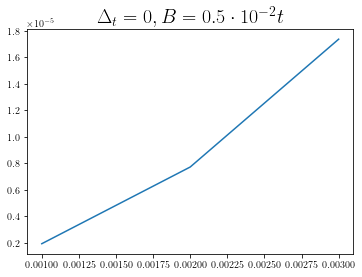

In [22]:
tx = 100
ty = 100

t = tx+ty

eff_mass_x_0 = 1/(2*tx)
eff_mass_y_0 = 1/(2*ty)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.title(r'$\Delta_t = 0,B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V_0_eff_mass_range[3:6]/t, eff_mass_to_plot(eff_mass1_x_B_1, eff_mass_x_0)[3:6], label=r'BW pert.')
#plt.plot(V_0_eff_mass_range[3:6]/t, eff_mass_to_plot(eff_mass1_x_B_200, eff_mass_y_0)[3:6], label=r'$B = 10^{0}t$')

print(len(v))
v = eff_mass_x_vGH_ratio.real[3:6]-1
verr = np.array([1e-6,5e-6,1e-5]) #np.ones(len(eff_mass_x_vGH_ratio.real[1:]))*1e-5
verr2 = np.array(verr)
verr2[verr>=v] = v[verr>=v]*.999999

#plt.scatter(V_eff_mass_vGH[3:6]/t, eff_mass_x_vGH_ratio[3:6].real-1, marker='x')
plt.errorbar(V_eff_mass_vGH[3:6]/t, eff_mass_x_vGH_ratio.real[3:6]-1, yerr=[verr2,verr], capsize=5, capthick=1, label=r'vGH')
#plt.scatter(V_eff_mass_vGH/t, eff_mass_to_plot(eff_mass_x_vGH.real, eff_mass_x_0), marker='x')

plt.plot(V_0_eff_mass_range[3:6]/200, 5e-5*V_0_eff_mass_range[3:6]**2, color='grey', linestyle='dashed', label=r'$1+5\cdot 10^{-5}V_0^2$')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m^*_x/m^*_0 - 1$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10) 

axs.legend(fontsize=15, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/pert_eff_mass_tx_100_ty_100.svg', bbox_inches='tight')

NameError: name 'v' is not defined

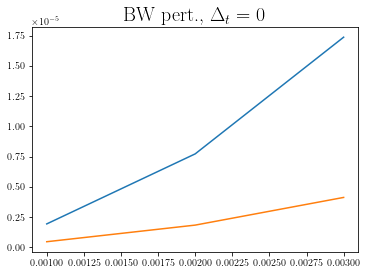

In [23]:
tx = 100
ty = 100

t = tx+ty

eff_mass_x_0 = 1/(2*tx)
eff_mass_y_0 = 1/(2*ty)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.title(r'BW pert., $\Delta_t = 0$', fontsize=font_size)

plt.plot(V_0_eff_mass_range[3:6]/t, eff_mass_to_plot(eff_mass1_x_B_1, eff_mass_x_0)[3:6], label=r'$B = 0.5\cdot 10^{-2}t$')
plt.plot(V_0_eff_mass_range[3:6]/t, eff_mass_to_plot(eff_mass1_x_B_200, eff_mass_y_0)[3:6], label=r'$B = 10^{0}t$')

print(len(v))
v = eff_mass_x_vGH_ratio.real[3:6]-1
verr = np.array([1e-6,5e-6,1e-5]) #np.ones(len(eff_mass_x_vGH_ratio.real[1:]))*1e-5
verr2 = np.array(verr)
verr2[verr>=v] = v[verr>=v]*.999999

#plt.scatter(V_eff_mass_vGH[3:6]/t, eff_mass_x_vGH_ratio[3:6].real-1, marker='x')
#plt.errorbar(V_eff_mass_vGH[3:6]/t, eff_mass_x_vGH_ratio.real[3:6]-1, yerr=[verr2,verr], capsize=5, capthick=1, label=r'vGH')
#plt.scatter(V_eff_mass_vGH/t, eff_mass_to_plot(eff_mass_x_vGH.real, eff_mass_x_0), marker='x')

plt.plot(V_0_eff_mass_range[3:6]/200, 5e-5*V_0_eff_mass_range[3:6]**2, color='grey', linestyle='dashed', label=r'$1+5\cdot 10^{-5}V_0^2$')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m^*_x/m^*_0 - 1$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10) 

axs.legend(fontsize=14, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/pert_eff_mass_tx_100_ty_100_bw_comp.svg', bbox_inches='tight')

In [ ]:
plt.plot(V_0_eff_mass_range/t, eff_mass1_x_B_2)
plt.plot(V_0_eff_mass_range/t, eff_mass1_x_B_200)

### Effective 1D Ferro-Domain Energies

In [24]:
V_eff_1D = np.array([0.0,0.02,0.04,0.2,0.4,30.0,60.0,90.0,120.0,150.0,180.0])
t = 200 

params["Mx"] = 2
params["My"] = 256

check_sys = 'tx_0_ty_100'
check_sym = '_B_2.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_0_qy_0'
folder = 'results/perturbation_theory/tx_0_ty_100/'
E_vGH1_eff1D = get_E_arr_eff_mass(V_eff_1D, folder, check_sys, check_sym)

print(E_vGH1_eff1D)
print(E_vGH1_eff1D+2*100)

[-199.99948987+3.21195727e-22j -199.94908526+4.07927098e-21j
 -199.94917748-1.77190629e-20j -199.95194821-3.73389934e-20j
 -199.96049266+5.04412588e-20j -241.68278079-2.06048656e-17j
 -312.94099689-4.96869109e-18j -392.7950885 -6.80177302e-17j
 -477.80985735-1.03577770e-16j -567.10643045+8.25989648e-17j
 -660.93529663+3.03933429e-17j]
[ 5.10127514e-04+3.21195727e-22j  5.09147369e-02+4.07927098e-21j
  5.08225202e-02-1.77190629e-20j  4.80517905e-02-3.73389934e-20j
  3.95073387e-02+5.04412588e-20j -4.16827808e+01-2.06048656e-17j
 -1.12940997e+02-4.96869109e-18j -1.92795088e+02-6.80177302e-17j
 -2.77809857e+02-1.03577770e-16j -3.67106430e+02+8.25989648e-17j
 -4.60935297e+02+3.03933429e-17j]


In [25]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_range_eff_1D = V_eff_1D.copy() # np.linspace(0,200,21) #np.append(V_0_range1, V_0_range2)

In [26]:
params["B"] = 2.0
params["tx"] = 0.0
params["ty"] = 100.0
t = params["tx"] + params["ty"]
Ep_pert_eff_1D_v1_B_2 = pert_pot_scan(params, V_0_range_eff_1D)
E_pert1_eff_1D_v1_B_2 = get_E_from_Ep(Ep_pert_eff_1D_v1_B_2, params["tx"], params["ty"])

print(E_pert1_eff_1D_v1_B_2)


Perturbative Calculations:
V0 = 0.0 , E = 0j
V0 = 0.02 , E = (-2.8213624643693536e-05+0j)
V0 = 0.04 , E = (-0.00011285209884597009+0j)
V0 = 0.2 , E = (-0.002819386035197789+0j)
V0 = 0.4 , E = (-0.011253754557567545+0j)
V0 = 30.0 , E = (-19.09717680756454+0j)
V0 = 60.0 , E = (-47.99999999999999+0j)
V0 = 90.0 , E = (-80.94275220818233+0j)
V0 = 120.0 , E = (-116.30497544930594+0j)
V0 = 150.0 , E = (-153.26123443818352+0j)
V0 = 180.0 , E = (-191.3284450982931+0j)
[-200.        +0.j -200.00002821+0.j -200.00011285+0.j -200.00281939+0.j
 -200.01125375+0.j -219.09717681+0.j -248.        +0.j -280.94275221+0.j
 -316.30497545+0.j -353.26123444+0.j -391.3284451 +0.j]


0.07053456158585983
[-2.82136246e-05+0.j -1.12852099e-04+0.j -2.81938604e-03+0.j
 -1.12537546e-02+0.j]
[0.00051013+3.21195727e-22j 0.05091474+4.07927098e-21j
 0.05082252-1.77190629e-20j 0.04805179-3.73389934e-20j
 0.03950734+5.04412588e-20j]


/nfs/scistore12/lemesgrp/fkluiben/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


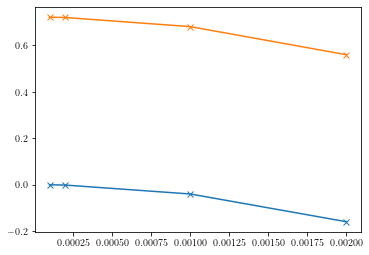

In [27]:
scale_fac = 2/(2*(2+4*100))**0.5
print(scale_fac)

plt.plot(V_eff_1D[1:5]/200, Ep_pert_eff_1D_v1_B_2[1:5]/scale_fac, marker='x')
plt.plot(V_eff_1D[1:5]/200, (E_vGH1_eff1D[1:5]+200)/scale_fac.real, marker='x')
#plt.plot(V_eff_1D[1:5]/200, (E_vGH1_eff1D[1:5]-E_vGH1_eff1D[0])/t, marker='x')

print(Ep_pert_eff_1D_v1_B_2[1:5])
print(E_vGH1_eff1D[0:5]+200)
#plt.xscale('log')
#plt.yscale('log')

In [28]:
def E_fd_analytic(V_0, B, t):
    return -2*V_0**2/(np.sqrt(B*(B+4*t)))

def find_Ep_eff_1D(V_0, t, B):
    Ep_implicit = lambda Ep: Ep+2*V_0**2/np.sqrt((B+2*t-Ep)**2 - 4*t**2)
    Ep_min = scipy.optimize.fsolve(Ep_implicit, [guess_Ep_eff_1D(V_0)])
    return Ep_min
    
def guess_Ep_eff_1D(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718

In [29]:
Ep_eff_1D_test = find_Ep_eff_1D(V_0_range_eff_1D, 100, 2)
E_eff_1D_test = get_E_from_Ep(Ep_eff_1D_test, 0, 200)

print(V_eff_1D, E_vGH1_eff1D+2*100)
print(V_0_range_eff_1D, Ep_eff_1D_test)
print(V_0_range_eff_1D, Ep_pert_eff_1D_v1_B_2)

print(Ep_pert_eff_1D_v1_B_2 - Ep_eff_1D_test)

[0.0e+00 2.0e-02 4.0e-02 2.0e-01 4.0e-01 3.0e+01 6.0e+01 9.0e+01 1.2e+02
 1.5e+02 1.8e+02] [ 5.10127514e-04+3.21195727e-22j  5.09147369e-02+4.07927098e-21j
  5.08225202e-02-1.77190629e-20j  4.80517905e-02-3.73389934e-20j
  3.95073387e-02+5.04412588e-20j -4.16827808e+01-2.06048656e-17j
 -1.12940997e+02-4.96869109e-18j -1.92795088e+02-6.80177302e-17j
 -2.77809857e+02-1.03577770e-16j -3.67106430e+02+8.25989648e-17j
 -4.60935297e+02+3.03933429e-17j]
[0.0e+00 2.0e-02 4.0e-02 2.0e-01 4.0e-01 3.0e+01 6.0e+01 9.0e+01 1.2e+02
 1.5e+02 1.8e+02] [ 3.55844897e-21 -2.82136246e-05 -1.12852099e-04 -2.81938604e-03
 -1.12537546e-02 -1.90971768e+01 -4.80000000e+01 -8.09427522e+01
 -1.16304975e+02 -1.53261234e+02 -1.91328445e+02]
[0.0e+00 2.0e-02 4.0e-02 2.0e-01 4.0e-01 3.0e+01 6.0e+01 9.0e+01 1.2e+02
 1.5e+02 1.8e+02] [ 0.00000000e+00+0.j -2.82136246e-05+0.j -1.12852099e-04+0.j
 -2.81938604e-03+0.j -1.12537546e-02+0.j -1.90971768e+01+0.j
 -4.80000000e+01+0.j -8.09427522e+01+0.j -1.16304975e+02+0.j
 -1.5

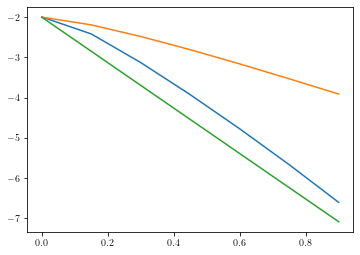

In [30]:
fig, axs = plt.subplots()

plt.plot(V_eff_1D/200, E_vGH1_eff1D.real/100)
plt.plot(V_0_range_eff_1D/200, -2+Ep_eff_1D_test/100)
plt.plot(V_0_range_eff_1D/200, -2-2*2**0.5*V_0_range_eff_1D/100)
#plt.plot(V_0_range/100, -E_to_plot(E_pert1_B_1.real, 100))
#plt.plot(V_0_range_eff_1D/200, -E_to_plot(E_eff_1D_test.real, 100))

#plt.xscale('log', base=10)
#plt.yscale('log', base=10)

#axs.invert_yaxis()

NameError: name 'E_pert1_B_1' is not defined

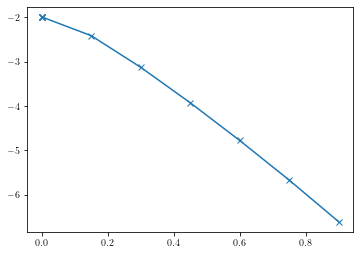

In [31]:
fig, axs = plt.subplots()

plt.plot(V_eff_1D/200, E_vGH1_eff1D.real/100, marker='x')
plt.plot(V_0_range/200, -2+E_pert1_B_1.real/200)
plt.plot(V_0_range_eff_1D/200, E_pert1_eff_1D_v1_B_2.real/100)
#plt.plot(V_0_range_eff_1D/200, E_fd_analytic(V_0_range_eff_1D, 1, 100)/200-2)
#plt.plot(V_0_range_eff_1D/200, (-2*100-np.sqrt(2)*V_0_range_eff_1D)/100)

plt.plot(V_0_range_eff_1D/200, E_eff_1D_test/50)

#plt.xscale('log', base=10)
#plt.yscale('log', base=10)

#axs.invert_yaxis()

In [33]:
plt.plot(V_0_range/200, E_pert1_B_1.real/100)

NameError: name 'E_pert1_B_1' is not defined

In [34]:
V_eff_1D

array([0.0e+00, 2.0e-02, 4.0e-02, 2.0e-01, 4.0e-01, 3.0e+01, 6.0e+01,
       9.0e+01, 1.2e+02, 1.5e+02, 1.8e+02])

### TODO: make here a comparison in the strong coupling and weak coupling as one can find it in conventional polaron literature! i.e. compare Mathieu functions in the strong coupling with BW perturbation theory in the weak coupling. It suffices to do this for one or two symmetry realizations!

## Strong Coupling pseudo Lang-Firsov transformation

In [35]:
def mathieu_energies(V_0, B, t):
    '''
    NOTE: the evaluation of the wavefunctions doesn't work for very large values of mathieu_param, i.e. for small B's there are problems!
    '''
    mathieu_param = 2*V_0/B
    E = (B/4)*4*scipy.special.mathieu_a(0, mathieu_param)
    
    return E

def E_to_plot_mathieu(E, t):
    return E/t #(E+2*t)/t #E/t #(E+2*t)/t

First, we compute the Mathieu energies for the desired coupling values. 

In [36]:
t = 200

'''
B = 2.0
'''
V_0_mathieu1 = np.array([200,400,600,800,1000,2000,10000,20000,100000,200000])
E_mathieu_B_2 = mathieu_energies(V_0=V_0_mathieu1, B=2, t=t)

'''
B = 2000.0
'''
V_0_mathieu2 = np.array([1000,2000,10000,20000,100000,200000])
E_mathieu_B_200 = mathieu_energies(V_0=V_0_mathieu2, B=2000, t=t)

Second, we get the results of the vGH wavefunctions.

In [37]:
V_0_mathieu_vGH1 = np.array([200,400,600,800,1000])

check_sys = 'tx_100_ty_100'
check_sym = '_B_2.0_Mx_8_My_8_qx_0_qy_0'
folder = 'results/perturbation_theory/tx_100_ty_100/sp/'
E_vGH_mathieu_B_2 = get_E_arr(V_0_mathieu_vGH1, folder, check_sys, check_sym)

V_0_mathieu_vGH2 = np.array([1000,2000,10000,20000,100000,200000])

check_sys = 'tx_100_ty_100'
check_sym = '_B_2000.0_Mx_16_My_16_qx_0_qy_0'
folder = 'results/perturbation_theory/tx_100_ty_100/sp/'
E_vGH_mathieu_B_200 = get_E_arr(V_0_mathieu_vGH2, folder, check_sys, check_sym)

Let's compare the numbers before plotting them.

In [38]:
print('V,E Mathieu for B=2 :', V_0_mathieu, E_mathieu_B_2)
print('V,E vGH for B=2 :', V_0_mathieu_vGH, E_vGH_mathieu_B_2)

print('\nV,E Mathieu for B=200 :', V_0_mathieu, E_mathieu_B_200)
print('V,E vGH for B=200 :', V_0_mathieu_vGH2, E_vGH_mathieu_B_200)

NameError: name 'V_0_mathieu' is not defined

### Result comparison between vGH and Mathieu energies

Here we just show that the vGH Ansatz reduces to the Mathieu basis in the strong coupling regime. Right now we don't do perturbation theory in the tunnelings. 

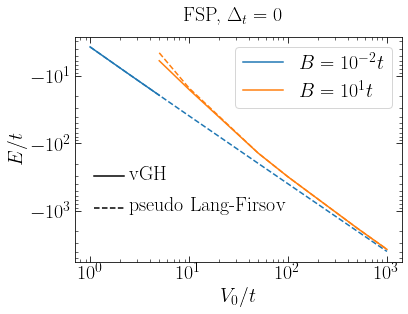

In [48]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FSP, $\Delta_t = 0$', fontsize=font_size)

axs.plot(V_0_mathieu_vGH1/t, -E_to_plot_mathieu(E_vGH_mathieu_B_2,t).real, color='tab:blue', linestyle='solid', label=r'$B = 10^{-2} t$')
axs.plot(V_0_mathieu1/t, -E_to_plot_mathieu(E_mathieu_B_2,t).real, color='tab:blue', linestyle='dashed')

axs.plot(V_0_mathieu_vGH2/t, -E_to_plot_mathieu(E_vGH_mathieu_B_200,t).real, color='tab:orange', linestyle='solid', label=r'$B = 10^{1} t$')
axs.plot(V_0_mathieu2/t, -E_to_plot_mathieu(E_mathieu_B_200,t).real, color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

#plt.xticks([1.0,2.0,3.0,4.0], fontsize=font_size)
#plt.yticks([-2,-6,-10,-14], fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_xticks([1e0,1e1,1e2,1e3],[r'$10^{0}$',r'$10^{1}$',r'$10^{2}$',r'$10^{3}$'], fontsize=font_size)
axs.set_yticks([1e1,1e2,1e3],[r'$-10^{1}$',r'$-10^{2}$',r'$-10^{3}$'], fontsize=font_size)

axs.plot(np.linspace(1.1,2.2,100), 0.3e3*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(1.1,2.2,100), 0.9e3*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(2.5,0.35e3), fontsize=font_size)
axs.annotate('pseudo Lang-Firsov', xy=(2.5,1e3), fontsize=font_size)

axs.legend(fontsize=font_size, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/perturbation_theory/strong_coupling_B_comp_tx_100_ty_100.svg', bbox_inches='tight')

We can also compare the Mathieu characteristic energies with the harmonic oscillator approximation, $\epsilon_k \approx 4\left(\sqrt{B V_0 / 2} - V_0\right)$.

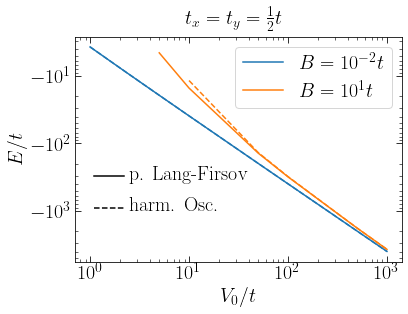

In [40]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'$t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_mathieu1/t, -E_to_plot_mathieu(E_mathieu_B_2,t).real, color='tab:blue', linestyle='solid', label=r'$B = 10^{-2} t$')
axs.plot(V_0_mathieu1/t, -E_to_plot_mathieu(-4*V_0_mathieu1+4*(2/2)**0.5*V_0_mathieu1**0.5,t).real, color='tab:blue', linestyle='dashed')

axs.plot(V_0_mathieu2/t, -E_to_plot_mathieu(E_mathieu_B_200,t).real, color='tab:orange', linestyle='solid', label=r'$B = 10^{1} t$')
axs.plot(V_0_mathieu2[1:]/t, -E_to_plot_mathieu(-4*V_0_mathieu2+4*(2000/2)**0.5*V_0_mathieu2**0.5,t).real[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_xticks([1e0,1e1,1e2,1e3],[r'$10^{0}$',r'$10^{1}$',r'$10^{2}$',r'$10^{3}$'], fontsize=font_size)
axs.set_yticks([1e1,1e2,1e3],[r'$-10^{1}$',r'$-10^{2}$',r'$-10^{3}$'], fontsize=font_size)

axs.plot(np.linspace(1.1,2.2,100), 0.3e3*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(1.1,2.2,100), 0.9e3*np.ones(100), linestyle='dashed', color='black')

axs.annotate('p. Lang-Firsov', xy=(2.5,0.35e3), fontsize=font_size)
axs.annotate('harm. Osc.', xy=(2.5,1e3), fontsize=font_size)

axs.legend(fontsize=font_size, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

### More rigorous estimate for the validity of the Mathieu approximation

TODO: this section is not finished yet. The main goal is to show in what regimes the Mathieu approximation holds based on the product of overlap and tunneling integral.

In [41]:
def overlap_null(n, V_0, B):
    x = (2*np.pi/n)*np.arange(n)
    mathieu_parameter = 2*V_0/B

    psi_l0 = n**(-0.5)*np.ones(n,dtype=complex)

    # top left
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-3*np.pi/4)/2*180/np.pi)
    ytl = y/np.sqrt(np.sum(y*y))

    # top right
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-np.pi/4)/2*180/np.pi)
    ytr = y/np.sqrt(np.sum(y*y))

    # bottom left
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x+3*np.pi/4)/2*180/np.pi)
    ybl = y/np.sqrt(np.sum(y*y))
        
    # bottom right
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x+np.pi/4)/2*180/np.pi)
    ybr = y/np.sqrt(np.sum(y*y))

    Ot = np.sum(ytl*psi_l0)*np.sum(ytr*ytl)*np.sum(psi_l0*ytr)
    Ob = np.sum(psi_l0*ybl)*np.sum(ybl*ybr)*np.sum(ybr*psi_l0)

    Ol = np.sum(psi_l0*ybl)*np.sum(ybl*ytl)*np.sum(ytl*psi_l0)
    Or = np.sum(psi_l0*ybr)*np.sum(ybr*ytr)*np.sum(ytr*psi_l0)

    Osum = Ot+Ob+Ol+Or
    #print(Ot, Ob, Ol, Or)
    return Ot

def overlap_one_or(n, V_0, B):
    x = (2*np.pi/n)*np.arange(n)
    mathieu_parameter = 2*V_0/B

    psi_l0 = n**(-0.5)*np.ones(n,dtype=complex)
    
    psi_l1 = (1/(2*np.pi)**0.5)*np.exp(-1j*x) #np.sin(x,dtype=complex)
    #psi_l1 = psi_l1/np.sqrt(np.sum(psi_l1*psi_l1))
    
    # top left
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-3*np.pi/4)/2*180/np.pi)
    ytl = y/np.sqrt(np.sum(y*y))

    y, yp = scipy.special.mathieu_sem(1, mathieu_parameter, (x-3*np.pi/4)/2*180/np.pi)
    ytl1 = y/np.sqrt(np.sum(y*y))
    
    # top right
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-np.pi/4)/2*180/np.pi)
    ytr = y/np.sqrt(np.sum(y*y))
    
    y, yp = scipy.special.mathieu_sem(1, mathieu_parameter, (x-np.pi/4)/2*180/np.pi)
    ytr1 = y/np.sqrt(np.sum(y*y))
    
    # bottom left
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x+3*np.pi/4)/2*180/np.pi)
    ybl = y/np.sqrt(np.sum(y*y))
        
    # bottom right
    y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x+np.pi/4)/2*180/np.pi)
    ybr = y/np.sqrt(np.sum(y*y))

    Ot = np.sum(np.conjugate(psi_l0)*ytl)*np.sum(np.conjugate(ytl)*ytr)*np.sum(np.conjugate(ytr)*psi_l1)
    Ot1 = np.sum(np.conjugate(psi_l0)*ytl)*np.sum(np.conjugate(ytl)*ytr1)*np.sum(np.conjugate(ytr1)*psi_l0)
    Ot2 = np.sum(np.conjugate(psi_l0)*ytl1)*np.sum(np.conjugate(ytl1)*ytr)*np.sum(np.conjugate(ytr)*psi_l0)
    Ob = np.sum(np.conjugate(psi_l1)*ybl)*np.sum(np.conjugate(ybl)*ybr)*np.sum(np.conjugate(ybr)*psi_l0)

    Ol = np.sum(np.conjugate(psi_l0)*ybl)*np.sum(np.conjugate(ybl)*ytl)*np.sum(np.conjugate(ytl)*psi_l1)
    Or = np.sum(np.conjugate(psi_l1)*ybr)*np.sum(np.conjugate(ybr)*ytr)*np.sum(np.conjugate(ytr)*psi_l0)

    Osum = Ot+Ob+Ol+Or
    #print(Ot1,Ot2,Ot1+Ot2)
    #print(Ot, Ob, Ol, Or)
    return Ot

#print('mathieu = ', E)
#    overlap_arr = np.zeros(len(V_0), dtype=complex)
#    for i in range(len(V_0)):
#        overlap_arr[i] = overlap_null(n=256, V_0=V_0[i], B=B)
#        print(overlap_arr[i])
        
        #overlap_arr[i] += np.absolute(overlap_one_or(n=256, V_0=V_0[i], B=B))
        #print(overlap_arr[i])

In [42]:
tx = 100
ty = 100
t = 200

V_0_pert_test = 100000

B_arr = np.array([2,20,200,400,2000]) #np.array([2,4,6,10,20,40,100,200,300]) #

overlap_zero = np.zeros(len(B_arr), dtype=complex)
overlap_exc = np.zeros(len(B_arr), dtype=complex)
for i in range(len(B_arr)):
    overlap_zero[i] = overlap_null(n=256, V_0=V_0_pert_test, B=B_arr[i])
    overlap_exc[i] = overlap_one_or(n=256, V_0=V_0_pert_test, B=B_arr[i])

tx_Or_00 = tx*overlap_zero/t
tx_Or_01 = -tx*overlap_exc/t

In [43]:
print(-(B_arr/4)*4*scipy.special.mathieu_a(0, 2*V_0_pert_test/B_arr)/t)
print(tx_Or_00)

[1993.67794567 1980.02503137 1937.00544694 1911.06012405 1802.53249152]
[           nan+nanj            nan+nanj 5.07824597e-06 +0.j
 1.01567220e-04 +0.j 6.61330407e-03 +0.j]


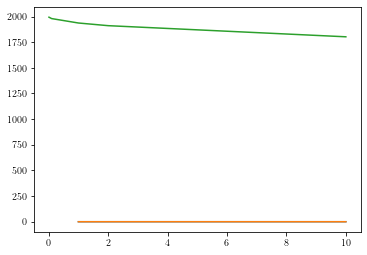

In [44]:
plt.plot(B_arr/t, tx_Or_00)
plt.plot(B_arr/t, tx_Or_01)
plt.plot(B_arr/t, -(B_arr/4)*4*scipy.special.mathieu_a(0, 2*V_0_pert_test/B_arr)/t)

/tmp/ipykernel_226783/770083785.py:6: RuntimeWarning: invalid value encountered in divide
  y = y/np.sqrt(np.sum(y*y))
/tmp/ipykernel_226783/770083785.py:9: RuntimeWarning: invalid value encountered in divide
  y1 = y1/np.sqrt(np.sum(y1*y1))


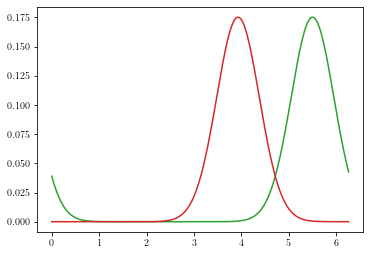

In [45]:
n = 256
x = (2*np.pi/n)*np.arange(n)

mathieu_parameter = 2*2000/2.0
y, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-3*np.pi/4)/2*180/np.pi)
y = y/np.sqrt(np.sum(y*y))

y1, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-np.pi/4)/2*180/np.pi)
y1 = y1/np.sqrt(np.sum(y1*y1))

mathieu_parameter = 2*50
ye, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-3*np.pi/4)/2*180/np.pi)
ye = ye/np.sqrt(np.sum(ye*ye))

ye1, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x-np.pi/4)/2*180/np.pi)
ye1 = ye1/np.sqrt(np.sum(ye1*ye1))

plt.plot(x,y)
plt.plot(x,y1)

plt.plot(x,ye)
plt.plot(x,ye1)

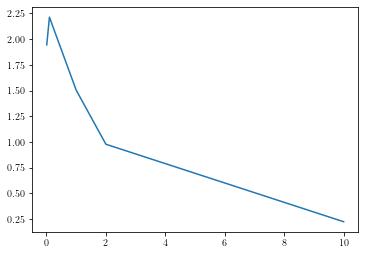

In [46]:
overlap_mat_exp = np.zeros(len(B_arr), dtype=complex)
for i in range(len(B_arr)):
    mathieu_parameter = 2*200/B_arr[i]
    y1, yp = scipy.special.mathieu_cem(0, mathieu_parameter, (x+3*np.pi/4)/2*180/np.pi)
    y1 = y1/np.sqrt(np.sum(y1*y1))

    overlap_mat_exp[i] = np.sum(np.conjugate(y1)*(1/(2*np.pi)**0.5)*np.exp(-1j*x))

plt.plot(B_arr/t, overlap_mat_exp)